# Import lib

In [1]:
import requests
import pandas as pd
import folium
import time
import random
import matplotlib.pyplot as plt
import datetime
import pprint

In [2]:
#1 choisir une ville par numero de departement
#2 afficher la population de la ville comme un fun fact (avec une ampoule à coté)
#3 récupérer la liste des piezomètres avec l'opération 'station'
#4 afficher la position des n piézomètre
#5 Selectionner un piezomètre
#6 afficher les courbe de la chronique avec l'opération 'chronique'

# Recuperer le code Inses

In [3]:
def recup_commune(code_postale):
    #addresse api
    curl = f'https://geo.api.gouv.fr/communes?codePostal={str(code_postale)}'
    #requete api
    commune_req = requests.get(curl).json()
    
    #json
    commune = commune_req[0]
    
    #info
    insee = commune['code']
    ville = commune['nom']
    population = commune['population']
    
    return insee, ville, population

In [4]:
code_postale = 67000

insee, ville, population = recup_commune(code_postale)

print("{} possède une population de {:,.0f} habitants".format(ville, population))

Strasbourg possède une population de 287,228 habitants


# Recuperer la liste des stations

In [5]:
def recup_list_stations(insee, ville):
    #code de la ville
    insee_str = str(insee)
    #url pour la requete
    station_url = f'https://hubeau.eaufrance.fr/api/v1/niveaux_nappes/stations?code_commune={insee_str}&format=json&size=20&pretty'
    station_req = requests.get(station_url).json()
    #list des stations piezometriques
    stations = station_req['data']

    print(f"il y a {len(stations)} station(s) à {ville}")
    
    return station_req, stations

In [6]:
station_req, stations = recup_list_stations(insee, ville)

il y a 20 station(s) à Strasbourg


# Choisir une station

In [7]:
def print_station_date(station):
    #information pour être print
    n_mesures = station['nb_mesures_piezo']
    date_debut = station['date_debut_mesure']
    date_fin = station['date_fin_mesure']
    
    #recupère date sous format Timestamp
    date_debut = pd.to_datetime(date_debut)
    date_fin = pd.to_datetime(date_fin)
    
    #calcul deltat 
    delta_t = date_fin - date_debut
    delta_t_an = delta_t.days / 365
    delta_t_mois = delta_t.days / 30
    
    #mise en forme
    delta_t_str = "{:.2f}".format(delta_t_an)
    moy = n_mesures/(delta_t_mois) #permet d'avoir une idée de la résolution temporelle du graphique
    moy_str = "{:.2f} mesures/mois".format(moy)
    
    #mise en forme des dates debut et fin
    date_debut_str = date_debut.strftime("%Y-%m-%d")
    date_fin_str = date_fin.strftime("%Y-%m-%d")
    
    print(f"il y a {n_mesures} mesures | {date_debut_str} -> {date_fin_str} ({delta_t_str} ans) | moyenne = {moy_str}")

## Celle qui a le plus de mesures

In [8]:
def station_max_mesure(stations):
    mesure_max = 0
    code_bss = ''
    station = {}

    for s in stations:
        mesures = s['nb_mesures_piezo']
        if mesures > mesure_max:
            mesure_max = mesures
            code_bss = s['code_bss']
            station = s
    
    print(f"la station {code_bss} possède le plus de mesure avec {mesure_max} mesures.")
    
    return station

station = station_max_mesure(stations)

la station 02723X0900/245R1 possède le plus de mesure avec 1682 mesures.


In [9]:
print_station_date(station)

il y a 1682 mesures | 1988-06-16 -> 2022-02-22 (33.71 ans) | moyenne = 4.10 mesures/mois


## une au hasard

In [10]:
def random_station(stations):
    n_stations = len(stations) - 1
    idx = random.randint(0,n_stations)

    station = stations[idx]
    
    print_station_date(station)
    
    return station

station_hasard = random_station(stations)

il y a 384 mesures | 1969-06-07 -> 1990-01-18 (20.63 ans) | moyenne = 1.53 mesures/mois


## Faire une liste

In [11]:
df_stations = pd.DataFrame(stations) 
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None 

In [12]:
cols = ['code_bss', 'date_debut_mesure', 'date_fin_mesure', 'x', 'y', 'nb_mesures_piezo', 'date_maj']
df_stations_light = df_stations[cols]

df_stations_light['date_debut_mesure'] = pd.to_datetime(df_stations_light['date_debut_mesure'])
df_stations_light['date_fin_mesure'] = pd.to_datetime(df_stations_light['date_fin_mesure'])

In [13]:
#moyenne nb_mesure / mois
df_stations_light['delta_t'] = df_stations_light['date_fin_mesure'] - df_stations_light['date_debut_mesure']
df_stations_light['delta_t_mois'] = df_stations_light['delta_t'].dt.days / 30
df_stations_light['moyenne_mesure_mois'] = df_stations_light['nb_mesures_piezo'] / df_stations_light['delta_t_mois']

In [14]:
sortBy = ['nb_mesures_piezo']

df_stations_light.sort_values(by=sortBy, ascending=False)

,code_bss,date_debut_mesure,date_fin_mesure,x,y,nb_mesures_piezo,date_maj,delta_t,delta_t_mois,moyenne_mesure_mois
19,02723X0900/245R1,1988-06-16,2022-02-22,7.748164,48.583983,1682,Tue Jan 28 19:02:12 CET 2020,12304 days,410.133333,4.101105
12,02723X0098/245A1,1966-07-01,1999-12-16,7.766629,48.511892,1327,Tue Jan 28 19:02:11 CET 2020,12221 days,407.366667,3.257508
13,02347X0060/GA1,1968-11-12,1997-01-13,7.809233,48.602935,596,Wed Apr 22 08:06:25 CEST 2020,10289 days,342.966667,1.737778
14,02723X0238/SOC1,1969-06-07,1990-01-18,7.748228,48.582438,384,Wed Apr 22 20:39:08 CEST 2020,7530 days,251.000000,1.529880
0,02723X0255/SOC10,1969-05-10,1985-12-16,7.783675,48.594645,250,Wed Apr 22 20:39:08 CEST 2020,6064 days,202.133333,1.236807
6,02723X0189/SOC11,1969-05-08,1985-12-16,7.760567,48.565818,247,Wed Apr 22 20:39:08 CEST 2020,6066 days,202.200000,1.221563
7,02723X0279/SOC21,1969-09-18,1985-12-16,7.741601,48.587244,210,Thu Apr 23 07:32:19 CEST 2020,5933 days,197.766667,1.061857
2,02723X0361/SOC30,1969-10-21,1997-01-29,7.784080,48.541528,196,Thu Apr 23 07:32:19 CEST 2020,9962 days,332.066667,0.590243
10,02723X0878/GET41,1988-10-21,1996-06-27,7.752935,48.577733,117,Wed Apr 22 20:39:08 CEST 2020,2806 days,93.533333,1.250891
5,02347X0001/501,1967-07-19,1998-01-28,7.804221,48.632254,107,Wed Apr 22 08:04:52 CEST 2020,11151 days,371.700000,0.287867


In [15]:
def return_list_position(df_stations):

    positions_df = df_stations[['y', 'x', 'nb_mesures_piezo']]

    list_positions = []
    labels = []

    for i in positions_df.index:
        lon = positions_df.iloc[i, 0]
        lat = positions_df.iloc[i, 1]
        nbre_mesure = positions_df.iloc[i, 2]

        loc = (lon, lat)

        list_positions.append(loc)
        labels.append(nbre_mesure)
        
    return list_positions, labels

In [16]:
from ipyleaflet import Map, Marker

positions, labels = return_list_position(df_stations)

center = positions[0]

m = Map(center=center, zoom=10)

for loc in positions:
    marker = Marker(location=loc, draggable=False)
    m.add_layer(marker)

m

Map(center=[48.594645, 7.783675], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

In [17]:
# affiche la localisation de la station slectionnée
loc = (station['y'], station['x'])

m = Map(center=loc, zoom=15)
marker = Marker(location=loc, draggable=False)
m.add_layer(marker)
m

Map(center=[48.583983073, 7.748164097], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

In [29]:
station

{'code_bss': '02723X0900/245R1',
 'urn_bss': 'http://services.ades.eaufrance.fr/pointeau/02723X0900/245R1',
 'date_debut_mesure': '1988-06-16',
 'date_fin_mesure': '2022-02-22',
 'code_commune_insee': '67482',
 'nom_commune': 'Strasbourg',
 'x': 7.748164097,
 'y': 48.583983073,
 'codes_bdlisa': ['221AA19'],
 'urns_bdlisa': ['http://reseau.eaufrance.fr/geotraitements/bdlisa/files/entite/221AA19.pdf'],
 'geometry': {'type': 'Point',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
  'coordinates': [7.74816409653114, 48.5839830730888]},
 'bss_id': 'BSS000VAXH',
 'altitude_station': '141.51',
 'nb_mesures_piezo': 1682,
 'code_departement': '67',
 'nom_departement': 'Bas-Rhin',
 'libelle_pe': 'Puits de PLACE DES ETUDIANTS',
 'profondeur_investigation': 10.4,
 'codes_masse_eau_edl': ['CG101'],
 'noms_masse_eau_edl': ['Nappe d’Alsace, Pliocène de Haguenau et Oligocène'],
 'urns_masse_eau_edl': ['http://www.sandre.eaufrance.fr/geo/MasseDEauSouterraine/CG10

In [35]:
def station_to_map(station):
    cols = ['y', 'x']

    df_station = pd.DataFrame(station, index=[0])
    df_station = df_station[cols]
    df_station.rename(columns={'x':'lon'}, inplace=True)
    df_station.rename(columns={'y':'lat'}, inplace=True)
    
    return df_station

df_temp = station_to_map(station)
df_temp

,lat,lon
0,48.583983,7.748164


# Recup la chronique de la station

In [18]:
def recup_chronique(code_bss, size=5000):
    
    chronique_url = f'https://hubeau.eaufrance.fr/api/v1/niveaux_nappes/chroniques?code_bss={code_bss}&size={str(size)}'

    chronique_req = requests.get(chronique_url).json()
    chroniques = chronique_req['data']
    print(f"il y a {len(chroniques)} mesure(s)")
    
    return chronique_req, chroniques

In [19]:
code_bss = str(station['code_bss'])

chronique_req, chroniques = recup_chronique(code_bss, size=5000)

il y a 1682 mesure(s)


In [20]:
chronique_req.keys()

dict_keys(['count', 'first', 'last', 'prev', 'next', 'api_version', 'data'])

In [21]:
chroniques[0]

{'code_bss': '02723X0900/245R1',
 'urn_bss': 'http://services.ades.eaufrance.fr/pointeau/02723X0900/245R1',
 'date_mesure': '1988-06-16',
 'timestamp_mesure': 582422400000,
 'niveau_nappe_eau': 135.69,
 'mode_obtention': 'Valeur mesurée',
 'statut': 'Donnée contrôlée niveau 1',
 'qualification': 'Correcte',
 'code_continuite': '2',
 'nom_continuite': 'Point lié au point précédent',
 'code_producteur': '40494388800036',
 'nom_producteur': 'APRONA (40494388800036)',
 'code_nature_mesure': None,
 'nom_nature_mesure': None,
 'profondeur_nappe': 5.81}

<AxesSubplot:xlabel='date_mesure'>

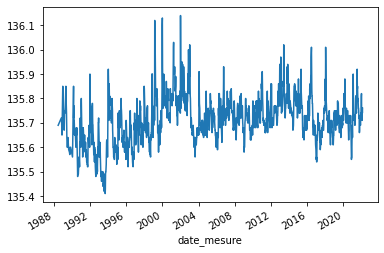

In [22]:
#transformation chroniques -> df time series

#chroniques (list) -> df
df_chronique_brut = pd.DataFrame(chroniques)
# df -> .csv
df_chronique_brut.to_csv('data.csv', index=False)
# csv -> df time series
df_chronique = pd.read_csv('data.csv', index_col='date_mesure', parse_dates=True)
#plot
df_chronique['niveau_nappe_eau'].plot()

In [23]:
df_chronique.head()

,code_bss,urn_bss,timestamp_mesure,niveau_nappe_eau,mode_obtention,statut,qualification,code_continuite,nom_continuite,code_producteur,nom_producteur,code_nature_mesure,nom_nature_mesure,profondeur_nappe
date_mesure,,,,,,,,,,,,,,
1988-06-16,02723X0900/245R1,http://services.ades.eaufrance.fr/pointeau/027...,582422400000,135.69,Valeur mesurée,Donnée contrôlée niveau 1,Correcte,2,Point lié au point précédent,40494388800036,APRONA (40494388800036),NaN,NaN,5.81
1988-10-21,02723X0900/245R1,http://services.ades.eaufrance.fr/pointeau/027...,593395200000,135.72,Valeur mesurée,Donnée contrôlée niveau 1,Correcte,1,Point initial,40494388800036,APRONA (40494388800036),NaN,NaN,5.78
1988-11-04,02723X0900/245R1,http://services.ades.eaufrance.fr/pointeau/027...,594604800000,135.70,Valeur mesurée,Donnée contrôlée niveau 1,Correcte,1,Point initial,40494388800036,APRONA (40494388800036),NaN,NaN,5.80
1988-11-18,02723X0900/245R1,http://services.ades.eaufrance.fr/pointeau/027...,595814400000,135.65,Valeur mesurée,Donnée contrôlée niveau 1,Correcte,1,Point initial,40494388800036,APRONA (40494388800036),NaN,NaN,5.85
1988-12-19,02723X0900/245R1,http://services.ades.eaufrance.fr/pointeau/027...,598492800000,135.85,Valeur mesurée,Donnée contrôlée niveau 1,Correcte,1,Point initial,40494388800036,APRONA (40494388800036),NaN,NaN,5.65


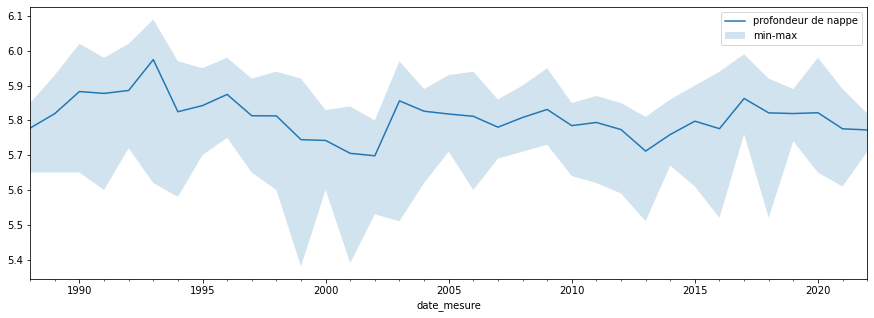

In [24]:
resample_size = 'Y'


#extrait les stats
nappe = df_chronique['profondeur_nappe'].resample(resample_size).agg(['mean', 'std', 'min', 'max'])

#plot
plt.figure(figsize=(15, 5))
nappe['mean'].plot(label='profondeur de nappe')
plt.fill_between(nappe.index, nappe['max'], nappe['min'], alpha=0.2, label='min-max')
plt.legend()
plt.show()

# Display chronique df

In [25]:
df_chronique.head(3)

,code_bss,urn_bss,timestamp_mesure,niveau_nappe_eau,mode_obtention,statut,qualification,code_continuite,nom_continuite,code_producteur,nom_producteur,code_nature_mesure,nom_nature_mesure,profondeur_nappe
date_mesure,,,,,,,,,,,,,,
1988-06-16,02723X0900/245R1,http://services.ades.eaufrance.fr/pointeau/027...,582422400000,135.69,Valeur mesurée,Donnée contrôlée niveau 1,Correcte,2,Point lié au point précédent,40494388800036,APRONA (40494388800036),NaN,NaN,5.81
1988-10-21,02723X0900/245R1,http://services.ades.eaufrance.fr/pointeau/027...,593395200000,135.72,Valeur mesurée,Donnée contrôlée niveau 1,Correcte,1,Point initial,40494388800036,APRONA (40494388800036),NaN,NaN,5.78
1988-11-04,02723X0900/245R1,http://services.ades.eaufrance.fr/pointeau/027...,594604800000,135.70,Valeur mesurée,Donnée contrôlée niveau 1,Correcte,1,Point initial,40494388800036,APRONA (40494388800036),NaN,NaN,5.80


In [26]:
cols_chronique = ['niveau_nappe_eau', 'profondeur_nappe', 'mode_obtention', 'code_producteur']
df = df_chronique[cols_chronique]

fn = f'piezo_{ville}_{code_bss}.csv'.replace('/','_')

df.to_csv(fn)